In [1]:
import numpy as np
from numpy.linalg import eig, det
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sympy as sp
from scipy.integrate import odeint
from scipy.optimize import fsolve

### Define Differential Equations

In [2]:
def trp_dynamics(x, t):
    """For simulating trp operon dynamics over time:
    x[0] : mRNA conc
    x[1] : enzyme conc
    x[2] : trp conc
    """
    r_m = 75
    alpha_1 = 0.9
    alpha_2 = 0.02
    alpha_3 = 0
    alpha_4 = 0.024
    alpha_5 = 430
    alpha_6 = -0.75
    k = 0.005
    k_a = 5.5
    k_i = 100
    k_r = 25
    u = 0.000048672
    
    r = r_m * x[2] / (x[2] + k_r)
    dx0_dt = (1 + x[2]) / (1 + (1 + r) * x[2]) * k_a / (k_a + x[2]) - (u + alpha_1) * x[0]
    dx1_dt = x[0] - (u + alpha_2) * x[1]
    dx2_dt = x[1] * (k_i**2) / ((k_i**2) + (x[2]**2)) - \
    (u + alpha_3) * x[2] - (alpha_4 * x[2]) / (1 + x[2]) * x[2] / (x[2] + k_r) - \
    alpha_5 * (1 + alpha_6 * u) * u * x[2] / (x[2] + k)
    
    dx_dt = [dx0_dt, dx1_dt, dx2_dt]
    return dx_dt

In [3]:
def trp_eqs(x):
    """For finding the fixed points and stability
    x[0] : mRNA conc
    x[1] : enzyme conc
    x[2] : trp conc
    """
    r_m = 75
    alpha_1 = 0.9
    alpha_2 = 0.02
    alpha_3 = 0
    alpha_4 = 0.024
    alpha_5 = 430
    alpha_6 = -0.75
    k = 0.005
    k_a = 5.5
    k_i = 100
    k_r = 25
    u = 0.000048672
    
    r = r_m * x[2] / (x[2] + k_r)
    dx0_dt = (1 + x[2]) / (1 + (1 + r) * x[2]) * k_a / (k_a + x[2]) - (u + alpha_1) * x[0]
    dx1_dt = x[0] - (u + alpha_2) * x[1]
    dx2_dt = x[1] * (k_i**2) / ((k_i**2) + (x[2]**2)) - \
    (u + alpha_3) * x[2] - (alpha_4 * x[2]) / (1 + x[2]) * x[2] / (x[2] + k_r) - \
    alpha_5 * (1 + alpha_6 * u) * u * x[2] / (x[2] + k)
    
    dx_dt = [dx0_dt, dx1_dt, dx2_dt]
    return dx_dt

### Numerical Integration

In [4]:
x0 = [20, 5, 100]
t = np.linspace(0, 500, 1000)

In [5]:
sol = odeint(trp_dynamics, x0, t)
sol

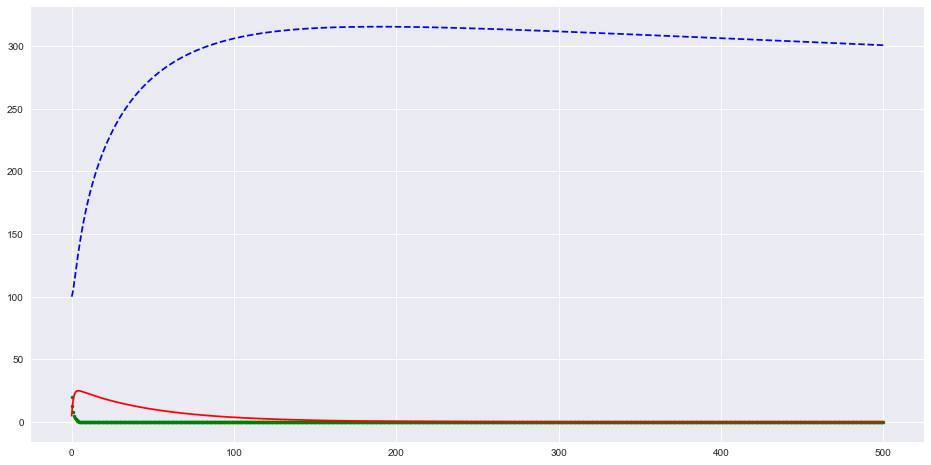

In [6]:
plt.figure(figsize=(16,8))
plt.plot(t, sol[:,0], 'g.')
plt.plot(t, sol[:,1], 'r-')
plt.plot(t, sol[:,2], 'b--')

### Solve for the Fixed Points
By solving for all DE's = 0 numerically

In [7]:
x_star, y_star, z_star =  fsolve(trp_eqs, (1, 1, 1))

In [8]:
print(x_star, y_star, z_star)

0.00133372035365 0.066524124573 75.4530243247


### Jacobian Matrix

In [9]:
(x, y, z) = sp.symbols('x, y, z', real=True)

In [10]:
dx, dy, dz = trp_eqs((x, y, z))

In [11]:
A = sp.Matrix([dx, dy, dz])

In [12]:
J = A.jacobian([x, y, z])

In [13]:
J

Matrix([
[-0.900048672,                    0, 5.5*(z + 1)*(-z*(-75*z/(z + 25)**2 + 75/(z + 25)) - 75*z/(z + 25) - 1)/((z + 5.5)*(z*(75*z/(z + 25) + 1) + 1)**2) - 5.5*(z + 1)/((z + 5.5)**2*(z*(75*z/(z + 25) + 1) + 1)) + 5.5/((z + 5.5)*(z*(75*z/(z + 25) + 1) + 1))],
[           1,         -0.020048672,                                                                                                                                                                                                                        0],
[           0, 10000/(z**2 + 10000),       -20000*y*z/(z**2 + 10000)**2 + 0.024*z**2/((z + 1)*(z + 25)**2) + 0.024*z**2/((z + 1)**2*(z + 25)) - 0.048*z/((z + 1)*(z + 25)) + 0.0209281960092442*z/(z + 0.005)**2 - 4.8672e-5 - 0.0209281960092442/(z + 0.005)]])

In [14]:
J_atFP = J.subs([(x, x_star), (y, y_star), (z, z_star)])
J_atFP

Matrix([
[-0.900048672,                 0, -1.89223920826946e-5],
[           1,      -0.020048672,                    0],
[           0, 0.637220337640592, -0.00051808583681829]])

### Evaluating Stability

In [15]:
trace = J_atFP.trace()
trace

-0.920615429836818

In [16]:
determinant = J_atFP.det()
determinant

-2.14064783338997e-5

In [17]:
eigens = J_atFP.eigenvects()

In [21]:
eigens # ==> eigenvalues, multiplicity, eigenvector

[(-0.0193205414982279 + 0.e-21*I, 1, [Matrix([
   [-2.14849411837386e-5 + 2.06795153138257e-25*I],
   [ -0.0295069924023904 + 1.58818677610181e-22*I],
   [                                          1.0]])]),
 (-0.00123098450496523 + 0.e-21*I, 1, [Matrix([
   [-2.10525363997125e-5 - 4.13590306276514e-25*I],
   [-0.00111876320643902 + 3.72231275648862e-24*I],
   [                                          1.0]])]),
 (-0.900063903833625 + 0.e-22*I, 1, [Matrix([
   [ 1.24229246119247 - 5.14709380157995e-25*I],
   [-1.41167154414361 + 3.02809990072286e-25*I],
   [                                       1.0]])])]